- LCC/RCC pairs
- Random 2000 images
- Image Preprocessing
    - Breast Cropping
    - 224 x 224 pixels
- Balanced datasets with 300 pairs of each classes

In [80]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.errors import InvalidDicomError
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D
from tensorflow.keras.models import Model
from collections import Counter
import numpy as np
import cv2

In [81]:
# Load the dataset
csv_path = '/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/data/Mammo/All_XWalk_Outcome_cleaned.csv'
data = pd.read_csv(csv_path, sep=',', quotechar='"', low_memory=False)

In [82]:
# Define the correct base path
correct_base_path = "/mnt/data1"

# Replace 'Q:\\' with the correct base path and standardize separators
data['FilePath'] = data['FilePath'].str.replace(r"^Q:\\", correct_base_path + "/", regex=True)
data['FilePath'] = data['FilePath'].str.replace(r"\\\\|\\", "/", regex=True)  # Replace backslashes with forward slashes

# Debugging: Print sample paths to verify
print(data['FilePath'].head())

# Filter out rows with invalid or missing FilePath
data = data.dropna(subset=['FilePath'])  # Remove rows with NaN in FilePath
data = data[data['FilePath'].apply(lambda x: isinstance(x, str))]  # Keep only string paths

0    /mnt/data1/BCWomen/BDenStorage/Screening/20130...
1    /mnt/data1/BCWomen/BDenStorage/Screening/20130...
2    /mnt/data1/BCWomen/BDenStorage/Screening/20130...
3    /mnt/data1/BCWomen/BDenStorage/Screening/20130...
4    /mnt/data1/BCWomen/BDenStorage/Screening/20130...
Name: FilePath, dtype: object


In [83]:
# Map ethnicity to 3 classes
def map_ethnicity(ethnicity):
    mapping = {
        "BR": "White", "EE": "White", "FR": "White", "NE": "White", "SE": "White", "WE": "White",
        "EA": "Asian - East and Southeast",
        "SA": "Asian - South"
    }
    return mapping.get(ethnicity, "Other")

data['ethnicity'] = data['ethnicity'].apply(map_ethnicity)

# Filter for selected ethnicities
data = data[data['ethnicity'].isin(["White", "Asian - East and Southeast", "Asian - South"])]

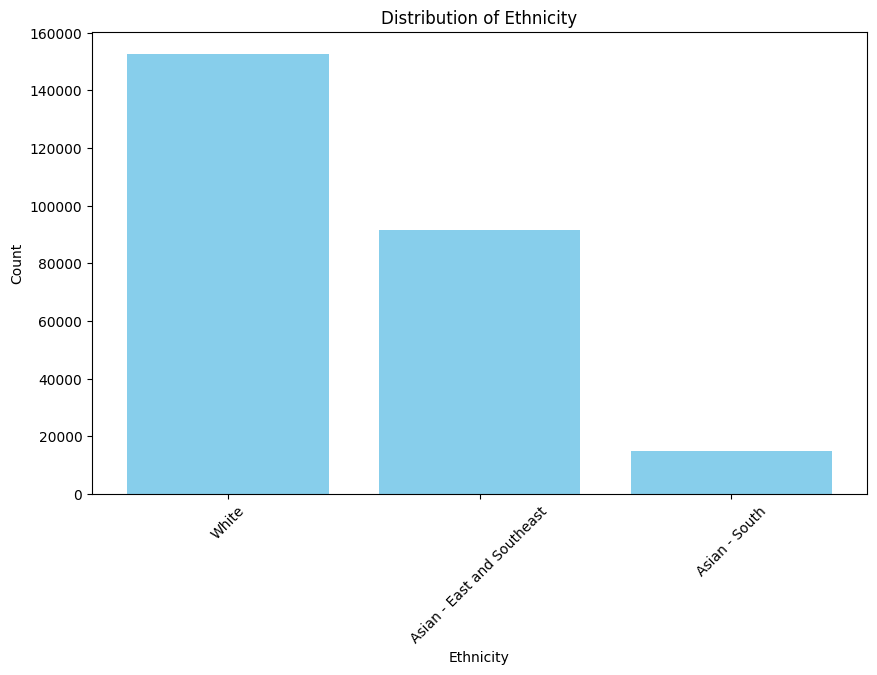

In [84]:
# Count ethnicity distribution
ethnicity_counts = data['ethnicity'].value_counts()
plt.figure(figsize=(10, 6))
# plt.style.use('default')
plt.bar(ethnicity_counts.index, ethnicity_counts.values, color='skyblue')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Distribution of Ethnicity')
plt.xticks(rotation=45)
plt.show()

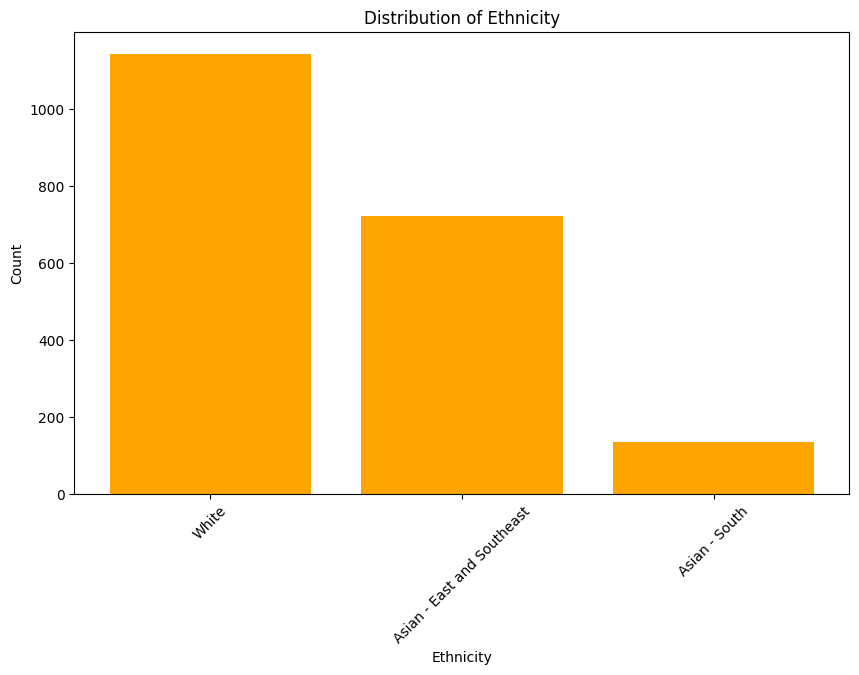

In [98]:
# Randomly select about 2000 images
data_sample = data.sample(n=2000, random_state=42)

# Show the distribution of ethnicity
ethnicity_counts = data_sample['ethnicity'].value_counts()
plt.figure(figsize=(10, 6))
# plt.style.use('default')
plt.bar(ethnicity_counts.index, ethnicity_counts.values, color='orange')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Distribution of Ethnicity')
plt.xticks(rotation=45)
plt.show()

In [99]:
def preprocess(pngPath, output_dir):
    img = cv2.imread(pngPath, cv2.IMREAD_GRAYSCALE)

    # Create a binary image for the breast by thresholding
    binary_img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)[1].astype(np.uint8)

    # Find all the contours in the binary image
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No contours found.")
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a mask for the breast region
    mask = np.zeros(img.shape, np.uint8)
    mask = cv2.fillPoly(mask, [largest_contour], 255)

    # Find the bounding box around the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image
    imgCropped = img[y:y+h, x:x+w]

    # Make the cropped image square by padding
    max_dim = max(w, h)
    padded_img = cv2.copyMakeBorder(
        imgCropped,
        top=(max_dim - h) // 2,
        bottom=(max_dim - h + 1) // 2,
        left=(max_dim - w) // 2,
        right=(max_dim - w + 1) // 2,
        borderType=cv2.BORDER_CONSTANT,
        value=0  # Background color (black)
    )

    # Save the processed image to a unique directory based on the original file path
    patient_dir = os.path.dirname(pngPath).replace("/", "_").replace("\\", "_")
    patient_output_dir = os.path.join(output_dir, patient_dir)
    os.makedirs(patient_output_dir, exist_ok=True)
    output_path = os.path.join(patient_output_dir, os.path.basename(pngPath))
    cv2.imwrite(output_path, imgCropped)
    cv2.imwrite(output_path, padded_img)

    return output_path

In [100]:
# Directory for saving preprocessed images
output_dir = "/tmp/processed_images"
os.makedirs(output_dir, exist_ok=True)

# Find valid LCC/RCC pairs and preprocess them
valid_filepaths = []
labels = []

for folder_path in data_sample['FilePath']:
    if os.path.exists(folder_path):
        all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
        lcc_files = [f for f in all_files if "LCC" in f]
        rcc_files = [f for f in all_files if "RCC" in f]
        if lcc_files and rcc_files:
            try:
                # Ensure LCC is on the left and RCC is on the right
                lcc_cropped_path = preprocess(lcc_files[0], output_dir)
                rcc_cropped_path = preprocess(rcc_files[0], output_dir)
                valid_filepaths.append((lcc_cropped_path, rcc_cropped_path))

                # Extract patient_id from the file path and match it to get ethnicity
                patient_id = os.path.basename(os.path.dirname(folder_path))
                matching_rows = data_sample[data_sample['patient_id'] == patient_id]
                if matching_rows.empty:
                    print(f"Warning: No matching label found for patient_id {patient_id}. Skipping.")
                    continue
                label = matching_rows['ethnicity'].iloc[0]
                labels.append(label)
            except Exception as e:
                print(f"Error processing {folder_path}: {e}")

# Standardize image placement (left=LCC, right=RCC)
valid_filepaths = [(lcc, rcc) for lcc, rcc in valid_filepaths if "LCC" in lcc and "RCC" in rcc]

# Display count of valid pairs
print(f"Number of valid LCC/RCC pairs: {len(valid_filepaths)}")
print(f"Ethnicity distribution in valid pairs: {Counter(labels)}")

Number of valid LCC/RCC pairs: 1226
Ethnicity distribution in valid pairs: Counter({'White': 754, 'Asian - East and Southeast': 387, 'Asian - South': 85})


In [114]:
# Preprocessing LCC images only
lcc_only_filepaths = []
lcc_only_labels = []

for folder_path in data_sample['FilePath']:
    if os.path.exists(folder_path):
        all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
        lcc_files = [f for f in all_files if "LCC" in f]
        if lcc_files:
            try:
                lcc_cropped_path = preprocess(lcc_files[0], output_dir)
                lcc_only_filepaths.append(lcc_cropped_path)

                # Extract patient_id from the file path and match it to get ethnicity
                patient_id = os.path.basename(os.path.dirname(folder_path))
                matching_rows = data_sample[data_sample['patient_id'] == patient_id]
                if matching_rows.empty:
                    print(f"Warning: No matching label found for patient_id {patient_id}. Skipping.")
                    continue
                label = matching_rows['ethnicity'].iloc[0]
                lcc_only_labels.append(label)
            except Exception as e:
                print(f"Error processing {folder_path}: {e}")

# # Display count of valid LCC-only images
# print(f"Number of valid LCC-only images: {len(lcc_only_filepaths)}")

# # Split LCC-only dataset into train/test datasets
# train_lcc_filepaths, test_lcc_filepaths, train_lcc_labels, test_lcc_labels = train_test_split(
#     lcc_only_filepaths, lcc_only_labels, test_size=0.2, stratify=lcc_only_labels, random_state=42
# )

In [121]:
# Downsample "White" class and upsample "Asian - South" class
white_indices = [i for i, label in enumerate(lcc_only_labels) if label == "White"]
asian_south_indices = [i for i, label in enumerate(lcc_only_labels) if label == "Asian - South"]
asian_east_indices = [i for i, label in enumerate(lcc_only_labels) if label == "Asian - East and Southeast"]

# Determine target size (same as Asian - East and Southeast)
target_size = 500 # len(asian_east_indices)

# Downsample "White"
downsampled_white_indices = random.sample(white_indices, 400)

# Upsample "Asian - South"
upsampled_asian_south_indices = resample(
    asian_south_indices,
    replace=True,
    n_samples=target_size,
    random_state=42
)

# Combine indices
final_indices = downsampled_white_indices + asian_east_indices + upsampled_asian_south_indices

# Create the balanced dataset
balanced_filepaths = [lcc_only_filepaths[i] for i in final_indices]
balanced_labels = [lcc_only_labels[i] for i in final_indices]

# Display count of balanced LCC-only images
print(f"Number of balanced LCC-only images: {len(balanced_filepaths)}")

# Split balanced LCC-only dataset into train/test datasets
train_lcc_filepaths, test_lcc_filepaths, train_lcc_labels, test_lcc_labels = train_test_split(
    balanced_filepaths, balanced_labels, test_size=0.2, stratify=balanced_labels, random_state=42
)

Number of balanced LCC-only images: 1300


In [122]:
# Convert LCC labels to numeric format
def encode_labels(labels):
    label_mapping = {label: idx for idx, label in enumerate(set(labels))}
    encoded_labels = [label_mapping[label] for label in labels]
    return encoded_labels, label_mapping

encoded_train_lcc_labels, lcc_label_mapping = encode_labels(train_lcc_labels)
encoded_test_lcc_labels = [lcc_label_mapping[label] for label in test_lcc_labels]

# Prepare LCC-only dataset for training
def create_lcc_dataset(filepaths, labels, augment=False):
    def load_lcc_image(filepath, augment):
        image = tf.image.decode_png(tf.io.read_file(filepath), channels=1)
        image = tf.image.resize(image, [224, 224])

        if augment:
            # Apply horizontal flipping randomly
            image = tf.image.random_flip_left_right(image)

        return image

    images = [load_lcc_image(filepath, augment) for filepath in filepaths]
    return tf.data.Dataset.from_tensor_slices((images, labels))

# Create LCC-only datasets with augmentation for training only
train_lcc_dataset = create_lcc_dataset(train_lcc_filepaths, encoded_train_lcc_labels, augment=True).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_lcc_dataset = create_lcc_dataset(test_lcc_filepaths, encoded_test_lcc_labels, augment=False).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [123]:
# Build EfficientNetB0 model with preprocessing for 1-channel input (LCC-only)
input_layer_lcc = Input(shape=(224, 224, 1))
base_model_lcc = EfficientNetB0(weights=None, include_top=False, input_tensor=Conv2D(3, (1, 1), activation='linear')(input_layer_lcc))

# Add custom layers on top of EfficientNetB0
x_lcc = base_model_lcc.output
x_lcc = GlobalAveragePooling2D()(x_lcc)
x_lcc = Dense(64, activation='relu')(x_lcc)
output_lcc = Dense(len(lcc_label_mapping), activation='softmax')(x_lcc)

model_lcc = Model(inputs=input_layer_lcc, outputs=output_lcc)

# Compile the model for LCC-only training
model_lcc.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model on LCC-only dataset
history_lcc = model_lcc.fit(
    train_lcc_dataset,
    validation_data=test_lcc_dataset,
    epochs=30,
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/30
33/33 [==============================] - 43s 1s/step - loss: 1.0733 - accuracy: 0.4644 - val_loss: 1.1208 - val_accuracy: 0.3077
Epoch 2/30
33/33 [==============================] - 29s 871ms/step - loss: 0.8266 - accuracy: 0.6144 - val_loss: 1.1170 - val_accuracy: 0.3846
Epoch 3/30
33/33 [==============================] - 30s 918ms/step - loss: 0.5878 - accuracy: 0.7615 - val_loss: 1.7152 - val_accuracy: 0.3077
Epoch 4/30
33/33 [==============================] - 29s 866ms/step - loss: 0.4875 - accuracy: 0.8144 - val_loss: 1.6961 - val_accuracy: 0.3077
Epoch 5/30
33/33 [==============================] - 28s 855ms/step - loss: 0.4162 - accuracy: 0.8596 - val_loss: 4.1453 - val_accuracy: 0.3077
Epoch 6/30
33/33 [==============================] - 29s 869ms/step - loss: 0.2387 - accuracy: 0.9212 - val_loss: 4.4488 - val_accuracy: 0.3077
Epoch 7/30
33/33 [==============================] - 29s 886ms/step - loss: 0.2246 - accuracy: 0.9269 - val_loss: 4.4883 - val_accuracy: 0.3077
Ep

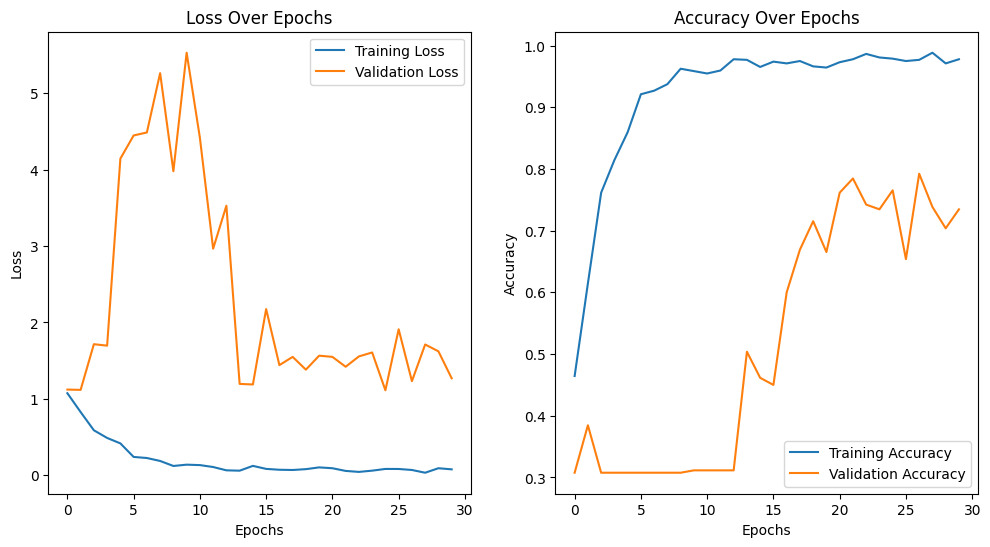

In [124]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(history_lcc.history['accuracy'], label='Training Accuracy')
plt.plot(history_lcc.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 1)
plt.plot(history_lcc.history['loss'], label='Training Loss')
plt.plot(history_lcc.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

9/9 [==============================] - 4s 170ms/step


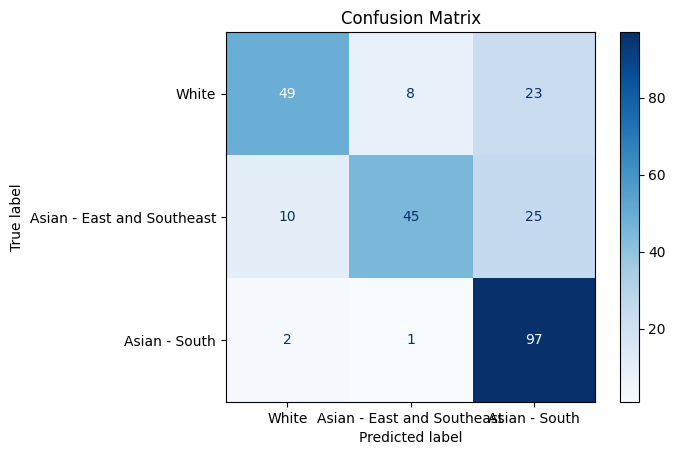

Classification Report:
                            precision    recall  f1-score   support

                     White       0.80      0.61      0.70        80
Asian - East and Southeast       0.83      0.56      0.67        80
             Asian - South       0.67      0.97      0.79       100

                  accuracy                           0.73       260
                 macro avg       0.77      0.71      0.72       260
              weighted avg       0.76      0.73      0.73       260



In [125]:
# Evaluate the model and compute metrics
predictions = model_lcc.predict(test_lcc_dataset)
predicted_labels = tf.argmax(predictions, axis=1).numpy()
true_labels = []
for _, labels in test_lcc_dataset:
    true_labels.extend(labels.numpy())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=list(lcc_label_mapping.keys())).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
print("Classification Report:")
print(classification_report(
    true_labels,
    predicted_labels,
    target_names=list(lcc_label_mapping.keys()),
    zero_division=1  # Sets undefined metrics to 1 instead of raising warnings
))


### LCC/RCC pairs

In [126]:
# Directory for saving preprocessed images
output_dir = "/tmp/processed_images"
os.makedirs(output_dir, exist_ok=True)

# Find valid LCC/RCC pairs and preprocess them
valid_filepaths = []
labels = []

for folder_path in data_sample['FilePath']:
    if os.path.exists(folder_path):
        all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
        lcc_files = [f for f in all_files if "LCC" in f]
        rcc_files = [f for f in all_files if "RCC" in f]
        if lcc_files and rcc_files:
            try:
                lcc_cropped_path = preprocess(lcc_files[0], output_dir)
                rcc_cropped_path = preprocess(rcc_files[0], output_dir)
                valid_filepaths.append((lcc_cropped_path, rcc_cropped_path))

                # Extract patient_id from the file path and match it to get ethnicity
                patient_id = os.path.basename(os.path.dirname(folder_path))
                matching_rows = data_sample[data_sample['patient_id'] == patient_id]
                if matching_rows.empty:
                    print(f"Warning: No matching label found for patient_id {patient_id}. Skipping.")
                    continue
                label = matching_rows['ethnicity'].iloc[0]
                labels.append(label)
            except Exception as e:
                print(f"Error processing {folder_path}: {e}")

# Display count of valid pairs
print(f"Number of valid LCC/RCC pairs: {len(valid_filepaths)}")
print(f"Ethnicity distribution in valid pairs: {Counter(labels)}")

Number of valid LCC/RCC pairs: 1629
Ethnicity distribution in valid pairs: Counter({'White': 878, 'Asian - East and Southeast': 628, 'Asian - South': 123})


In [127]:
# Split into train/test datasets
train_filepaths, test_filepaths, train_labels, test_labels = train_test_split(
    valid_filepaths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Resample only the training dataset
class_groups = {label: [] for label in set(train_labels)}
for filepath_pair, label in zip(train_filepaths, train_labels):
    class_groups[label].append(filepath_pair)

# Define target size for resampling
target_size = 700

balanced_train_filepaths = []
balanced_train_labels = []
for label, group in class_groups.items():
    if len(group) > target_size:
        sampled_group = random.sample(group, target_size)
    else:
        sampled_group = resample(group, replace=True, n_samples=target_size, random_state=42)
    balanced_train_filepaths.extend(sampled_group)
    balanced_train_labels.extend([label] * target_size)

# Check the new distribution
print("New training data distribution:")
print(Counter(balanced_train_labels))

print("Testing data distribution:")
print(Counter(test_labels))

New training data distribution:
Counter({'Asian - South': 700, 'White': 700, 'Asian - East and Southeast': 700})
Testing data distribution:
Counter({'White': 176, 'Asian - East and Southeast': 126, 'Asian - South': 24})


In [128]:
# Convert labels to numeric format
def encode_labels(labels):
    label_mapping = {label: idx for idx, label in enumerate(set(labels))}
    encoded_labels = [label_mapping[label] for label in labels]
    return encoded_labels, label_mapping

encoded_train_labels, label_mapping = encode_labels(balanced_train_labels)
encoded_test_labels = [label_mapping[label] for label in test_labels]

# Prepare dataset for training
def create_pairs_dataset(filepaths, labels, augment=False):
    def load_image_pair(lcc_path, rcc_path, augment):
        lcc_image = tf.image.decode_png(tf.io.read_file(lcc_path), channels=1)
        rcc_image = tf.image.decode_png(tf.io.read_file(rcc_path), channels=1)
        lcc_image = tf.image.resize(lcc_image, [224, 224])
        rcc_image = tf.image.resize(rcc_image, [224, 224])

        if augment:
            # Apply horizontal flipping randomly
            lcc_image = tf.image.random_flip_left_right(lcc_image)
            rcc_image = tf.image.random_flip_left_right(rcc_image)

        combined_image = tf.concat([lcc_image, rcc_image], axis=-1)
        return combined_image

    images = [load_image_pair(lcc, rcc, augment) for lcc, rcc in filepaths]
    return tf.data.Dataset.from_tensor_slices((images, labels))

# Create datasets with augmentation for training only
train_dataset = create_pairs_dataset(balanced_train_filepaths, encoded_train_labels, augment=True).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = create_pairs_dataset(test_filepaths, encoded_test_labels, augment=False).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [129]:
for image_batch, label_batch in train_dataset.take(1):
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")

Image batch shape: (32, 224, 224, 2)
Label batch shape: (32,)


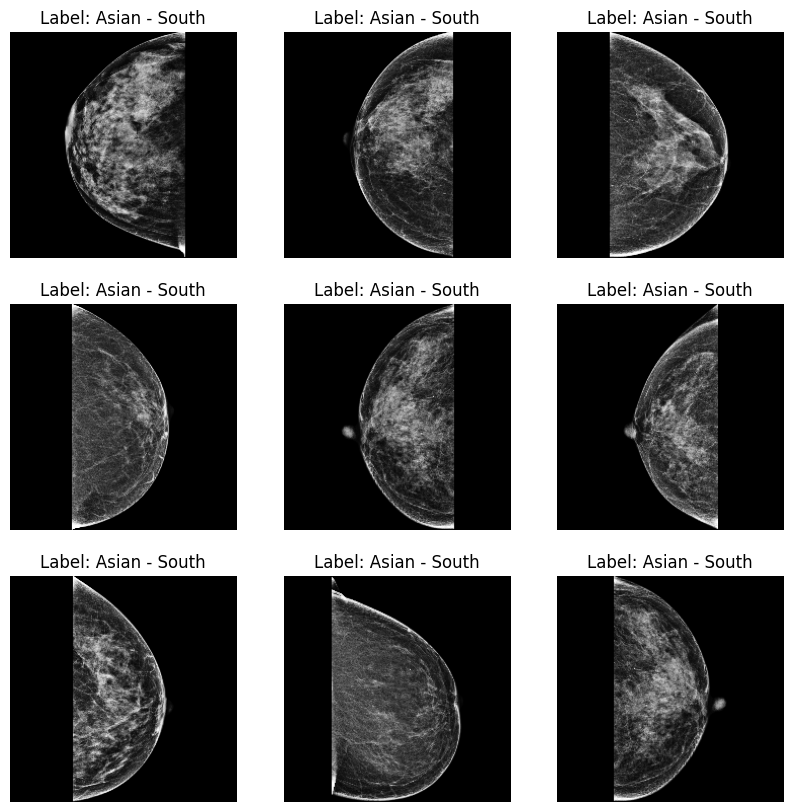

In [130]:
for image_batch, label_batch in train_dataset.shuffle(1000).take(1):  # Shuffle before taking samples
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(tf.squeeze(image_batch[i][:, :, 0].numpy()), cmap="gray")
        label = list(label_mapping.keys())[list(label_mapping.values()).index(label_batch[i].numpy())]
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.show()


In [131]:
# Build EfficientNetB0 model with preprocessing for 2-channel input
input_layer = Input(shape=(224, 224, 2))
processed_input = Conv2D(3, (1, 1), activation='linear')(input_layer)  # Convert 2 channels to 3
base_model = EfficientNetB0(weights=None, include_top=False, input_tensor=processed_input)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x) # 128
output = Dense(len(label_mapping), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=30,
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)


Epoch 1/30
66/66 [==============================] - 72s 954ms/step - loss: 2.1030 - accuracy: 0.5329 - val_loss: 1.0257 - val_accuracy: 0.5399
Epoch 2/30
66/66 [==============================] - 57s 862ms/step - loss: 1.2288 - accuracy: 0.5024 - val_loss: 1.1101 - val_accuracy: 0.3865
Epoch 3/30
66/66 [==============================] - 56s 843ms/step - loss: 1.0068 - accuracy: 0.5876 - val_loss: 1.0416 - val_accuracy: 0.5399
Epoch 4/30
66/66 [==============================] - 56s 854ms/step - loss: 1.3065 - accuracy: 0.3957 - val_loss: 0.9728 - val_accuracy: 0.3865
Epoch 5/30
66/66 [==============================] - 57s 865ms/step - loss: 1.2008 - accuracy: 0.2290 - val_loss: 1.0884 - val_accuracy: 0.3865
Epoch 6/30
66/66 [==============================] - 56s 853ms/step - loss: 1.2050 - accuracy: 0.6562 - val_loss: 1.0644 - val_accuracy: 0.3865
Epoch 7/30
66/66 [==============================] - 56s 844ms/step - loss: 1.1431 - accuracy: 0.3243 - val_loss: 1.1396 - val_accuracy: 0.3865

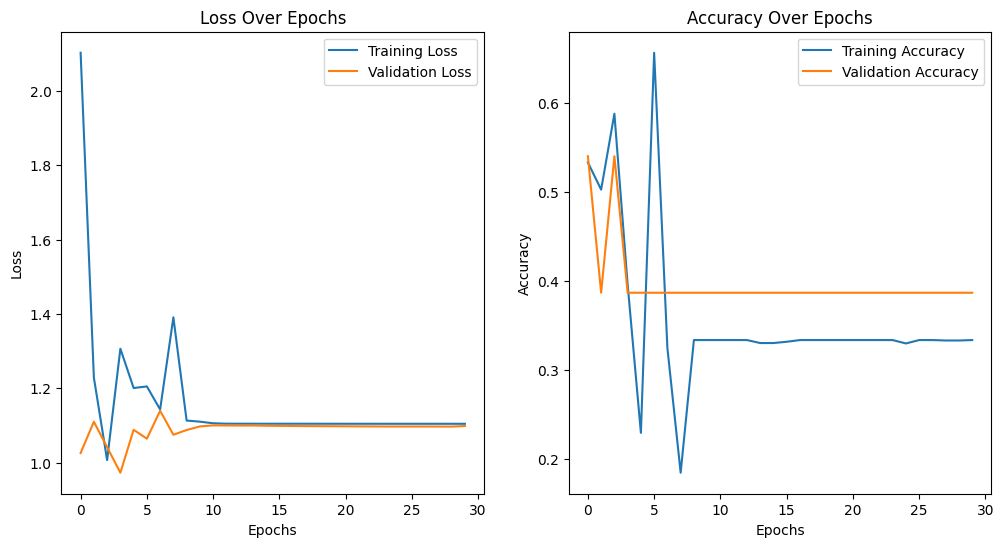

In [132]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

11/11 [==============================] - 8s 291ms/step


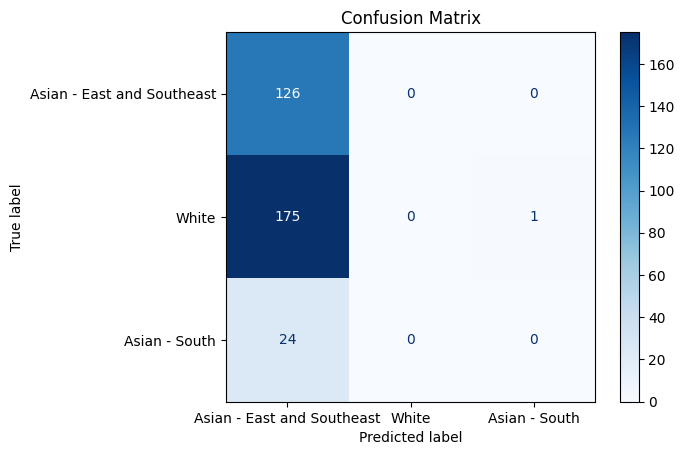

Classification Report:
                            precision    recall  f1-score   support

Asian - East and Southeast       0.39      1.00      0.56       126
                     White       1.00      0.00      0.00       176
             Asian - South       0.00      0.00      1.00        24

                  accuracy                           0.39       326
                 macro avg       0.46      0.33      0.52       326
              weighted avg       0.69      0.39      0.29       326



In [133]:
# Evaluate the model and compute metrics
predictions = model.predict(test_dataset)
predicted_labels = tf.argmax(predictions, axis=1).numpy()
true_labels = []
for _, labels in test_dataset:
    true_labels.extend(labels.numpy())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=list(label_mapping.keys())).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
print("Classification Report:")
print(classification_report(
    true_labels,
    predicted_labels,
    target_names=list(label_mapping.keys()),
    zero_division=1  # Sets undefined metrics to 1 instead of raising warnings
))


In [134]:
# Analyze predicted and true label distributions

print("Predicted label distribution:", Counter(predicted_labels))
print("True label distribution:", Counter(true_labels)) # Test label

Predicted label distribution: Counter({0: 325, 2: 1})
True label distribution: Counter({1: 176, 0: 126, 2: 24})
